# Домашнее задание 6: классификация текстов

В этом домашнем задании вам предстоит построить классификатор текстов и поучаствовать в соревновании на Kaggle!
Первым делом вам предстоит построить хороший бейзлайн, а дальше пытаться улучшать, соревнуясь с другими участниками.


Ссылка на соревнование: https://www.kaggle.com/c/avito-category-prediction/overview
Данные для домашнего задания можно скачать на странице соревнования.
Чтобы ваше участие было засчитано, убедитесь, что имя в Leaderboard имеет вид: «Имя Фамилия номер_группы».

Оценивание:

Домашнее задание оценивается как обычно. Баллы указаны напротив заданий.

За соревнование даются бонусные баллы следующим образом.
Если вы пересекли baseline_2 на приватном лидерборде, ваша оценка равна 

10 - 10 * (i - 1) / M

где M — количество студентов, принявших участие в соревновании;

i — место (начиная с 1) студента в приватном лидерборде среди всех таких студентов.

Правила:

* Домашнее задание оценивается в 10 баллов.

* Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

* Старайтесь сделать код как можно более оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек, о которых рассказывалось в курсе.  

* В течение 3 суток после окончания соревнования в соответствующее задание на anytask необходимо прислать код, воспроизводящий ответы для посылки, фигурирующей в приватном лидерборде. В случае отсутствия кода, воспроизводящего результат, в установленный срок студенту выставляется 0 в качестве оценки за соревнование. Если не оговорено иное, использовать любые внешние данные в соревнованиях '''запрещено'''. Под внешними данными понимаются размеченные данные, где разметка имеет прямое отношение к решаемой задаче. Грубо говоря, сборник текстов с википедии не считается внешними данными.


Мы будем работать с датасетом объявлений Avito. Нам предстоит по заголовку и тексту объявления предсказывать категорию объявления.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt

In [2]:
train = pd.read_csv('/Users/andreydyadyunov/Downloads/train.csv')
test = pd.read_csv('/Users/andreydyadyunov/Downloads/test.csv')

In [3]:
train.head()

,title,description,Category_name,Category
0,"Эбу Renault / Nissan 1,5 DCI Delphi 2001-2008 год","Комплект ЭБУ (мозги, компьютер мотора, двигате...",Запчасти и аксессуары,10
1,Утюг утп 1000 ватт СССР 1987 год,Продам/\n Фото № 1-2 /\n /\nУтюг УТП 1000 ватт...,Бытовая техника,21
2,Возвму машину с выкупом,Возьму машину в аренду с последующим выкупом н...,Предложение услуг,114
3,Полусапожки,"полусапожки в отличном состоянии, один раз оде...","Одежда, обувь, аксессуары",27
4,Босоножки кожаные,"Кожаные(натур) босоножки Karlo Pasolini, 40 рр...","Одежда, обувь, аксессуары",27


## Задание 1 (0.5 балла)

Выведете на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их пустой строкой.

In [4]:
print('Пропуски в трейне:')
train.isnull().sum()

Пропуски в трейне:


title            0
description      2
Category_name    0
Category         0
dtype: int64

In [5]:
train['description'] = train['description'].fillna('')
print('Пропуски в трейне:')
train.isnull().sum()

Пропуски в трейне:


title            0
description      0
Category_name    0
Category         0
dtype: int64

In [6]:
print('Пропуски в тесте:')
test.isnull().sum()

Пропуски в тесте:


title          0
description    1
itemid         0
dtype: int64

In [7]:
test['description'] = test['description'].fillna('')
print('Пропуски в тесте:')
test.isnull().sum()

Пропуски в тесте:


title          0
description    0
itemid         0
dtype: int64

## Задание 2 (0.5 балла)
Сконкатенируйте заголовок и описание в единую строку и поместите результат в отдельный столбец. Таким образом мы будет работать с одним текстом, а не с двумя.

In [8]:
train['title_description'] = train.title + ' ' + train.description
test['title_description'] = test.title + ' ' + test.description
train = train.drop(['title', 'description'], axis=1)
test = test.drop(['title', 'description'], axis=1)
train.head()

,Category_name,Category,title_description
0,Запчасти и аксессуары,10,"Эбу Renault / Nissan 1,5 DCI Delphi 2001-2008 ..."
1,Бытовая техника,21,Утюг утп 1000 ватт СССР 1987 год Продам/\n Фот...
2,Предложение услуг,114,Возвму машину с выкупом Возьму машину в аренду...
3,"Одежда, обувь, аксессуары",27,"Полусапожки полусапожки в отличном состоянии, ..."
4,"Одежда, обувь, аксессуары",27,Босоножки кожаные Кожаные(натур) босоножки Kar...


## Задание 3 (0.5 балла)
Давайте немного посмотрим на наши данные. Визуализируйте (где явно просят) или выведете информацию о следующем:

1. Сколько всего уникальных классов необходимо предсказать?
2. Постройте столбчатую диаграмму распределения по классам. Нормализуйте график, чтобы видеть доли, а не абсолютные значения.
3. На сколько большой дисбаланс? Какой класс имеет самую большую долю в выборке (укажите класс и долю), какой класс наименьшую (укажите класс и долю).

Необходимо предсказать:
50 строк
Наибольшую долю имеет класс: Одежда, обувь, аксессуары - 0.1807067572782698
Наименьшую долю имеет класс: Недвижимость за рубежом - 3.8969854337769914e-05


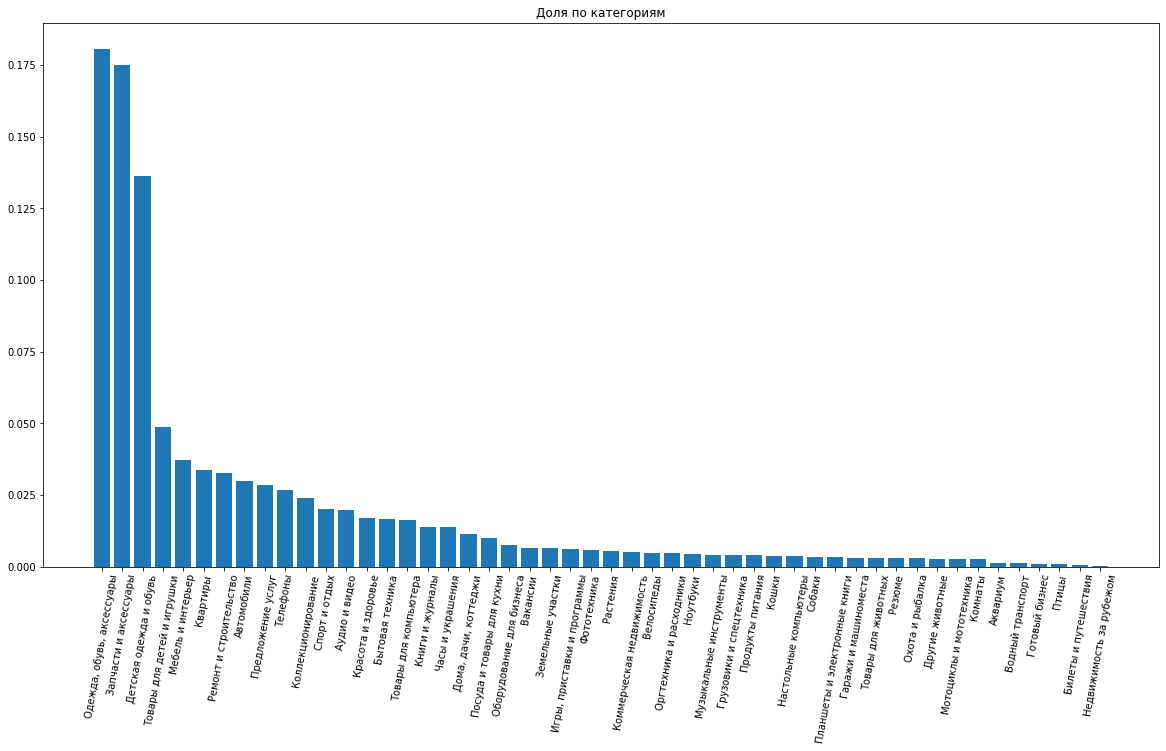

In [9]:
print('Необходимо предсказать:\n{rows} строк'.format(rows=len(train.Category.unique())))
fig = plt.figure(figsize=(20, 10))
plt.xticks(rotation=80)
plt.title('Доля по категориям')
df = pd.DataFrame(train['Category_name'].value_counts())
df['categ'] = df.index
df = df.reset_index(drop = True)
plt.bar(df['categ'], df['Category_name']/df['Category_name'].sum())
print('Наибольшую долю имеет класс: {maxi} - {part1}\nНаименьшую долю имеет класс: {mini} - {part2}'.format(maxi=df.categ[0], mini=df.categ[49], part1=(df.Category_name[0]/df.Category_name.sum()), part2=(df.Category_name[49]/df.Category_name.sum())))

## Задание 4 (0.5 балла)

Далее мы будем пока работать только с train частью. Для test части нам неизвестны истинные значения, и они понадобятся только тогда, когда мы будем отправлять решение на Kaggle.

1. Предобработайте данные (train часть) с помощью CountVectorizer.
2. Какого размера получилась матрица?


In [10]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(train.title_description)

In [11]:
print('Размер матрицы:')
X.shape


Размер матрицы:


(4234042, 2125805)

## Задание 5 (0.5 балла)

В предыдущем пункте у вас должная была получится очень большая матрица. Это не дело.
Если вы взгляните на текст, то увидете, что там есть множество специальных символов.

Давайте также посмотрим на словарь, который получился в результате построения CountVectorizer, его можно найти в поле _vocabulary инстанса этого класса.

1. Найдите в этом словаре все слова, которые начинаются на цифру. Сколько таких слов нашлось?

2. Найдите все слова, которые начинаются на символы пунктуации. Сколько таких слов нашлось? 

In [12]:
df1 = pd.DataFrame(vectorizer.vocabulary_.keys(), columns=['words'])
df1['numbers'] = 0
for j, i in enumerate(df1.words):
    if i[0] in '0123456789': 
        df1.numbers[j] = 1
    else:
        pass

<ipython-input-12-e1d560f19ab2>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.numbers[j] = 1


In [13]:
print("Элементов начинающихся на цифру:\n{numb}".format(numb=df1.numbers.sum()))

Элементов начинающихся на цифру:
610871


In [14]:
from string import punctuation as punc_lst
df1['punctuation'] = 0
for j, i in enumerate(df1.words):
    if i[0] in punc_lst: 
        df1.punctuation[j] = 1
    else:
        pass

<ipython-input-14-dbaf10a797c1>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.punctuation[j] = 1


In [15]:
print("Элементов начинающихся на знак препинания:\n{punc}".format(punc=df1.punctuation.sum()))

Элементов начинающихся на знак препинания:
2043


## Задание 6 (2.5 балла)

В scikit-learn мы можем оценивать процесс подсчета матрицы через CountVectorizer. У CountVectorizer, как и у других наследников \_VectorizerMixin, есть аргумент tokenizer и preprocessor. preprocessor применится в самом начале к каждой строке вашего датасета, tokenizer же должен принять строку и вернуть токены.
Давайте напишем кастомный токенайзер, которые сделает все, что нам нужно: 

0. Приведет все буквы к нижнему регистру
1. Разобьет текст на токены с помощью word_tokenizer из пакета nltk
2. Удалит все токены содержащие числа и пунктуацию
3. Удалит все токены, которые перечислены в nltk.corpus.stopwords('russian')
4. Проведет стемминг с помощью SnowballStemmer

Продемонстрируйте работу вашей функии на самом первом описании товара в датасете.

Важно: так как функию будет необходимо запускать на большом корпусе, подумайте об эффективной реализации. Постарайтесь решить задачу в минимальное количество циклов и копирований.

Референсная реализация на компьютере автора работала 230 секунд на 100к строчек.

In [16]:
!pip install nltk
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/andreydyadyunov/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/andreydyadyunov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [17]:
import re
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("russian")
def preprocessor(string):
    string = string.lower()
    string = word_tokenize(string)
    df = pd.DataFrame(string ,columns = ['tokens'])
    string = df.loc[~df['tokens'].isin(list(stopwords.words('russian'))) == True].values.tolist()
    description_new = []
    for i in string:
        if re.search(r'[\d\W]',i[0]) == None:
            description_new.append(i[0])

    return description_new

def tokenizer (string: str):
    string = [stemmer.stem(s) for s in string]
    return string


## Задание 7 (1 балл)

1. Возьмите случайные 500к строк из датасета. Постройте по ним CountVectorizer с применением вашего токенизатора.
2. Разбейте полученную матрицу на train, test в отношении 4 к 1. Не забудьте про target переменную.
3. Обучите SGDClassifier на полученной выборке.
4. Посчитайте метрику accuracy

In [18]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
classifier = SGDClassifier()
df3 = train[['Category', 'title_description']].sample(n=100000, random_state=4)
X = df3.title_description
Y = df3.Category
vectorizer = CountVectorizer(tokenizer=lambda x: tokenizer(x), preprocessor=lambda y: preprocessor(y))
X = vectorizer.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=4)
classifier.fit(X_train, y_train)
y_test_pred = classifier.predict(X_test)
accuracy_score(y_test_pred, y_test)

0.83445

## Задание 8 (1 балл)

1. Повторите 7 задание, но с tf-idf векторизатором. Как изменилось качество.
2. Мы можем еще сильнее уменьшите размер нашей матрицы, если отбросим значения df близкие к единице. Скорее всего такие слова не несут много информации о категории, так как встречаются достаточно часто. Ограничьте максимальный df в параметрах TfIdfVectorizer, поставьте верхнюю границу равную 0.9. Как изменился размер матрицы, как изменилось качество?


In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(tokenizer=lambda x: tokenizer(x), preprocessor=lambda y: preprocessor(y), max_df=0.9)
X = df3.title_description
Y = df3.Category
X_tfid = vectorizer.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_tfid, Y, test_size=0.2, random_state=4)
classifier.fit(X_train, y_train)
y_test_pred = classifier.predict(X_test)
accuracy_score(y_test_pred, y_test)

0.83315

Качество улучшилось

## Задание 9 (1 балл)
Еще один популяпный трюк, который позволит уменьшить количество признаков называется hashing trick. Его суть в том, то мы случайно группируем признаки ииии  ..... складываем их! А потом удаляем исходные признаки. В итоге все наши признаки это просто суммы исходных. Звучит странно, но это отлично работает. Давайте проверим этот трюк в нашем сеттинге.
Также при таком подходе вам не нужно хранить словарь token->index, что тоже иногда полезно.

1. Повторите задание 7 с HashingVectorizer, укажите количество фичей равное 30000.
2. Какой из трех подходов показал самый высокий результат?

In [20]:
from sklearn.feature_extraction.text import HashingVectorizer
vectorizer = HashingVectorizer(tokenizer=lambda x: tokenizer(x), preprocessor=lambda y: preprocessor(y), n_features=30000)
X = df3.title_description
Y = df3.Category
X_hash = vectorizer.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_hash, Y, test_size=0.2, random_state=4)
classifier.fit(X_train, y_train)
y_test_pred = classifier.predict(X_test)
accuracy_score(y_test_pred, y_test)

/Users/andreydyadyunov/Downloads/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:484: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


0.8161

## Задание 10 (1.5 балла)

Пришло время выйти в мир. Отправляйтесь на Kaggle Inclass и сделайте первую посылку. Там вы найдете инструкцию как сформировать файл с предсказаниями и отправить его.

Не помню точно, какой вариант дал лучший результат
Но мне разрешили отправить несколько
ВАРИАНТ 1:

In [21]:
vectorizer = TfidfVectorizer(tokenizer=lambda x: tokenizer(x), preprocessor=lambda y: preprocessor(y), max_df=0.8)
df4 = train[['title_description', 'Category']]
X = df4.title_description
Y = df4.Category
X_tfid = vectorizer.fit_transform(X)

In [31]:
X_test = test['title_description']
X_test = vectorizer.transform(X_test)

In [39]:
classifier = SGDClassifier(max_iter=4000, alpha=0.0000001, penalty='elasticnet', l1_ratio=0.05)

In [35]:
classifier.fit(X_tfid, Y)

SGDClassifier(alpha=1e-07, l1_ratio=0.03, max_iter=4000, penalty='elasticnet')

In [36]:
y_train_pred = classifier.predict(X_tfid)
accuracy_score(y_train_pred, Y)

0.9205078740362046

In [37]:
y_test_pred = classifier.predict(X_test)

In [38]:
predictions1=pd.DataFrame(y_test_pred, columns=['Category'])
predictions1['id'] = test.itemid
predictions1.to_csv('predictions12.csv', index=False)

ВАРИАНТ 2:

In [ ]:
vectorizer = TfidfVectorizer(tokenizer=lambda x: tokenizer(x), preprocessor=lambda y: preprocessor(y), max_df=0.85)
df4 = train[['title_description', 'Category']]
X = df4.title_description
Y = df4.Category
X_tfid = vectorizer.fit_transform(X)

In [ ]:
X_test = test['title_description']
X_test = vectorizer.transform(X_test)

In [ ]:
classifier = SGDClassifier(max_iter=4000, alpha=0.0000001)

In [ ]:
classifier.fit(X_tfid, Y)

In [ ]:
y_train_pred = classifier.predict(X_tfid)
accuracy_score(y_train_pred, Y)

In [ ]:
y_test_pred = classifier.predict(X_test)

In [ ]:
predictions1=pd.DataFrame(y_test_pred, columns=['Category'])
predictions1['id'] = test.itemid
predictions1.to_csv('predictions_new.csv', index=False)